In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import os
import argparse
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
import torch.nn.functional as F
import copy
from PIL import Image
import matplotlib.pyplot as plt
import json
from collections import OrderedDict
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [ ]:
data_dir = 'drive/MyDrive/flowers_dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
batch_size = 5

Создаем  трансформер, которые последовательно выполняет 2 трансформации исходного изображения: 
- преобразует исходное изображение в тензор
- выполняет по-канальную нормализацию яркости изображения

Данные трансформации необходимы для подачи изображений на входно слой предобученной сети. 





In [ ]:
transformer = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], 
                                                        [0.229, 0.224, 0.225]
                                                       )
                                  ])

In [ ]:
image_datasets = dict()
image_datasets['train'] = datasets.ImageFolder(train_dir, transform=transformer)
image_datasets['valid'] = datasets.ImageFolder(valid_dir, transform=transformer)
image_datasets['test'] = datasets.ImageFolder(test_dir, transform=transformer)

dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size)
dataloaders['test']  = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size)


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

print ("Dasaset Size: {}".format(dataset_sizes))
print ("Classes: {}".format(class_names))

Dasaset Size: {'train': 193, 'valid': 65, 'test': 133}
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Ниже объявлена функция, в которой производится обучение модели.
Процесс обучения следующий:
- в ходе каждой эпохи мы работаем с тренировочным и валидационным наборами данных
- для обоих наборов высчитывается точность и значение функции потерь (в качестве функции потерь мы взяли кросс-энтропию)
- при работе с тренировочным набором выполняется градиентный спуск
- при работе с валидационным набором выполняется поиск параметров модели, при которых была достигнута наибольшая точность классификации

In [ ]:
def train_model(model, num_epochs):
    history = {
        'loss' : {
            'train' : np.zeros(num_epochs),
            'valid': np.zeros(num_epochs)
        },
        'accuracy' : {
            'train' : np.zeros(num_epochs),
            'valid': np.zeros(num_epochs)
        }
    }
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    best_model_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        for phase in ['train', 'valid']:
            # we train model, only when phase == 'train'
            model.train(phase == 'train')

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data                
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} -  Loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_state = copy.deepcopy(model.state_dict())
            
            history['loss'][phase][epoch] = epoch_loss
            history['accuracy'][phase][epoch] = epoch_acc

        print('-' * 10)

    print('Best validation accuracy: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_state)
    return model, history

Здесь мы загружаем предобученную модель

In [ ]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

А здесь добавляем слои к преобученной модели, формируя классификатор непосредственно под нашу задачу.

PS интересное рнаблюдение - LogSoftmax дает лучшие результаты по сравнению с Softmax

In [ ]:
num_features = model.classifier[0].in_features

classifier = nn.Sequential(OrderedDict([
                              ('hidden1', nn.Linear(num_features, 64)),
                              ('relu', nn.ReLU()),
                              ('drpot', nn.Dropout(p=0.5)),
                              ('hidden2', nn.Linear(64, 10)),
                              ('output', nn.LogSoftmax(dim=1)),
                              ]))

model.classifier = classifier

In [ ]:
num_epochs = 5
model = model.cuda()

model, history = train_model(model, num_epochs)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train -  Loss: 2.1051 Accuracy: 0.4352
valid -  Loss: 0.5118 Accuracy: 0.9385
----------
Epoch 2/5
train -  Loss: 0.6828 Accuracy: 0.7772
valid -  Loss: 0.2408 Accuracy: 0.9538
----------
Epoch 3/5
train -  Loss: 0.4875 Accuracy: 0.8238
valid -  Loss: 0.1843 Accuracy: 0.9385
----------
Epoch 4/5
train -  Loss: 0.2658 Accuracy: 0.8964
valid -  Loss: 0.1505 Accuracy: 0.9385
----------
Epoch 5/5
train -  Loss: 0.2841 Accuracy: 0.9067
valid -  Loss: 0.1994 Accuracy: 0.9385
----------
Best validation accuracy: 0.953846


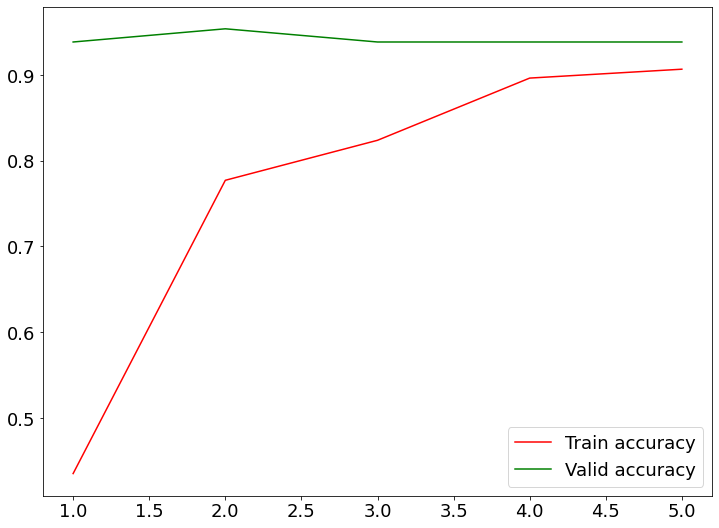

In [ ]:
plt.figure(figsize=(12, 9))
plt.rcParams.update({'font.size': 18})
plt.plot(range(1, num_epochs + 1), history['accuracy']['train'], label='Train accuracy', color='red')
plt.plot(range(1, num_epochs + 1), history['accuracy']['valid'], label='Valid accuracy', color='green')
plt.legend()

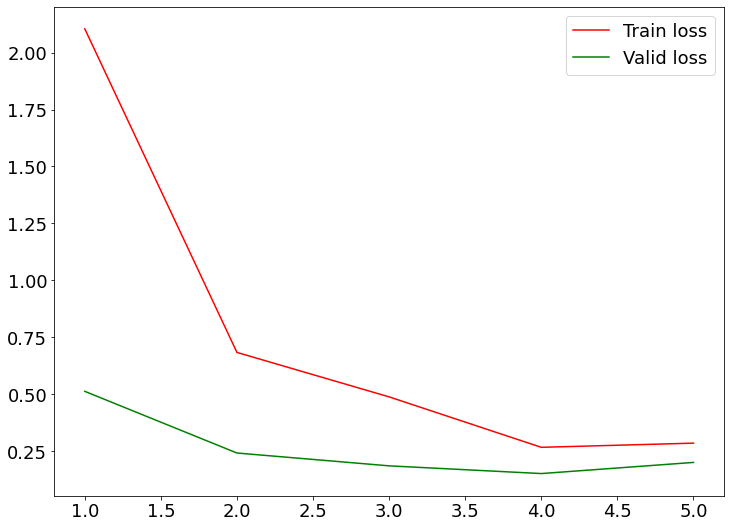

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(range(1, num_epochs + 1), history['loss']['train'], label='Train loss', color='red')
plt.plot(range(1, num_epochs + 1), history['loss']['valid'], label='Valid loss', color='green')
plt.legend()

Ниже описана функция, тестирующая обученную модель на данных, которые модель еще не видела.

In [ ]:
def perform_testing():
    criterion = nn.CrossEntropyLoss()
    model.train(False)
    test_data_size = len(dataloaders['test'])
    y_true = []
    y_pred = []

    with torch.no_grad():
      accuracy = 0
      test_loss = 0
      for i, (images, labels) in enumerate(dataloaders['test']):

          inputs = Variable(images.cuda())
          labels = Variable(labels.cuda())

          output = model.forward(inputs)
          test_loss += criterion(output, labels).data

          output = torch.exp(output).data
          equality = (labels.data == output.max(1)[1])
          for j in range(len(labels.data)):
              y_true.append(labels.data[j].item())
              y_pred.append(output.max(1)[1][j].item())
          accuracy += equality.type_as(torch.FloatTensor()).mean()

    print("Test Loss: {:.3f} ".format(test_loss/test_data_size),
          "Test Accuracy: {:.3f}".format(accuracy/test_data_size))
    return y_true, y_pred

y_true, y_pred = perform_testing()

Test Loss: 0.400  Test Accuracy: 0.881


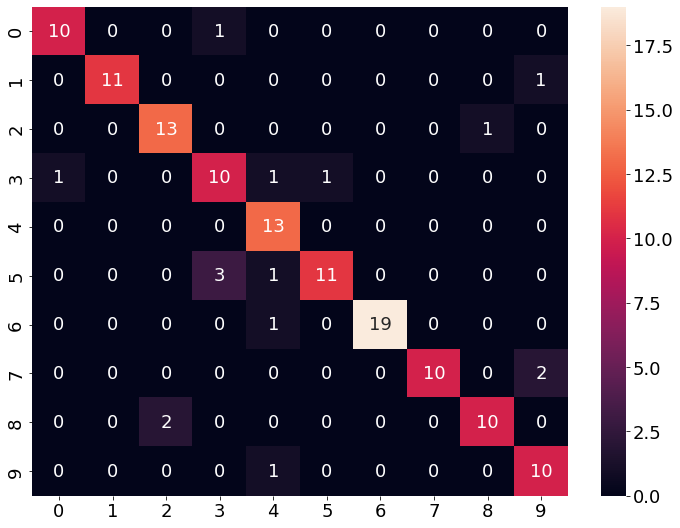

In [ ]:
matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 9))
sn.heatmap(matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d')